# Covid Scans Classification Using Simple Methods
In this notebook we'll try to classify patients as having covid or not based on their scans. We'll use simple machine learning methods first, then switch to CNNs.

Data can be downloaded here : https://drive.google.com/file/d/1WS9WiABZM_ODhN6kSRoVSOik51mU3vI7/view

In [1]:
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

## Importing the Images using PIL

In [2]:
import glob
image_list_covid = []
image_list_non_covid = []
for filename in glob.glob('covid/COVID/*'): 
    im=Image.open(filename)
    image_list_covid.append(im)
for filename in glob.glob('covid/non-COVID/*'): 
    im=Image.open(filename)
    image_list_non_covid.append(im)

## Visualize some scans

### Covid-Positive scans

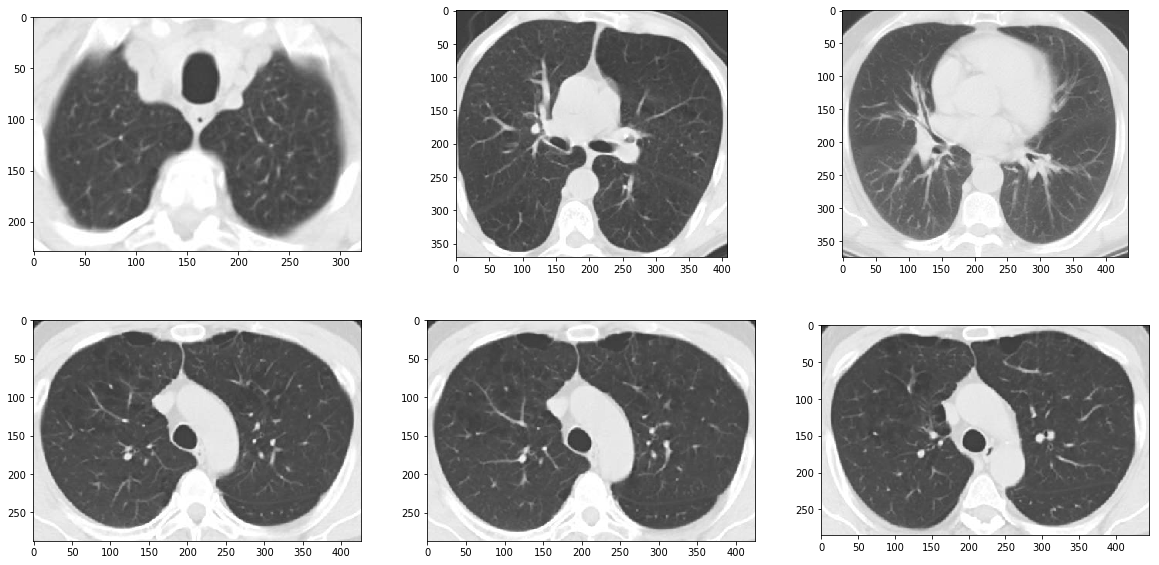

In [3]:
Nb_row = 2
Nb_col = 3
fig, axs = plt.subplots(Nb_row, Nb_col, figsize=(20,10))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(image_list_non_covid[i])

### Covid-Negative scans

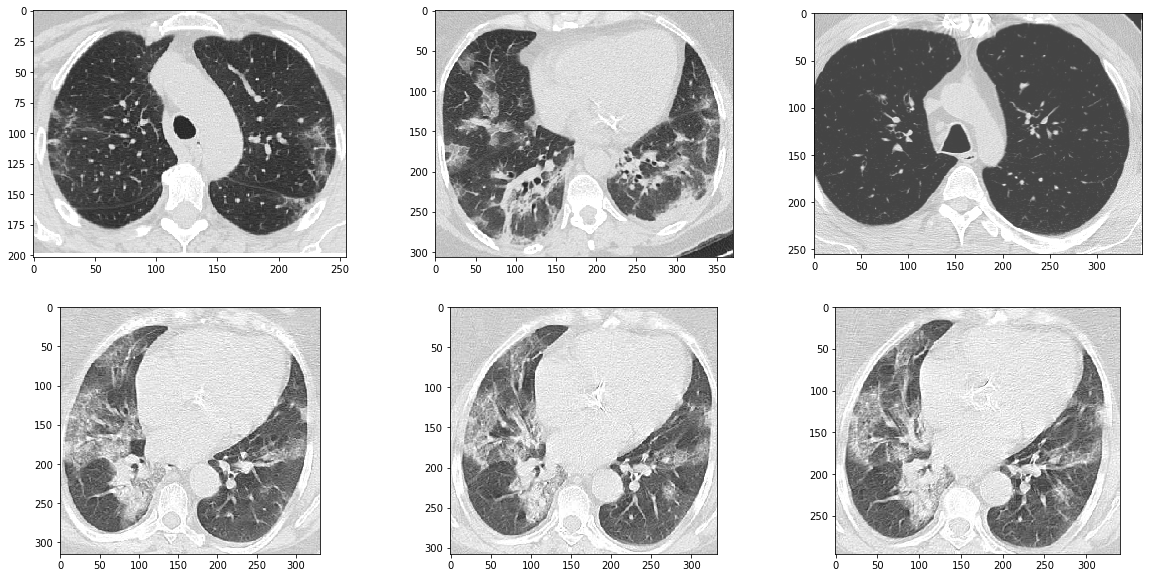

In [4]:
fig, axs = plt.subplots(Nb_row, Nb_col, figsize=(20,10))

for i,ax in enumerate(axs.flatten()):
    ax.imshow(image_list_covid[i])

## Preprocessing 

Here we have to :
 - First convert the images to Grayscale
 - Resize the images to a fixed size (100*100) for e.g
 - Flatten the data

In [5]:
# Convert resize and flatten
images_numpy_covid = []
WIDTH,HEIGHT = 100,100
for im in image_list_covid:
    images_numpy_covid.append(np.array(im.convert('LA').resize((WIDTH,HEIGHT)))[:,:,0].flatten())

images_numpy_no_covid = []
for im in image_list_non_covid:
    images_numpy_no_covid.append(np.array(im.convert('LA').resize((WIDTH,HEIGHT)))[:,:,0].flatten())

The images are now represented as 100*100 = 10000 * 1 vectors

In [6]:
images_numpy_no_covid[0].shape

(10000,)

We have 1252 Covid-Positive scans and 1229 Covid-Negative scans

In [7]:
len(images_numpy_covid)

1252

In [8]:
len(images_numpy_no_covid)

1229

### Generating the labels and the matrix of all images

The first `len(images_numpy_covid)` images are in class "1" (Positive). And the last `len(images_numpy_no_covid)` images are in class "0" (Negative).

We generate accordingly the labels vector `Y`

In [9]:
Y = [1] * len(images_numpy_covid)
Y.extend([0] * len(images_numpy_no_covid)) 

In [10]:
Y = np.array(Y)

Then we create the matrix of all image vectors by concatenating the two lists :

In [11]:
X = images_numpy_covid + images_numpy_no_covid

## Training the Model

In [12]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

First of all, we split our data into 70% Training and 30% Testing, and  then we'll try a bunch of very simple models before diving into more sophisticated ones :

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

### Logistic Regression

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
cl = LogisticRegression()

In [17]:
cl.fit(X_train, Y_train)

LogisticRegression()

Accuracy : 0.7946308724832215
F1-Score : 0.7951807228915663
Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       368
           1       0.80      0.79      0.80       377

    accuracy                           0.79       745
   macro avg       0.79      0.79      0.79       745
weighted avg       0.79      0.79      0.79       745

Confusion Matrix


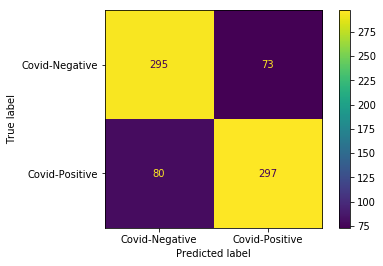

In [18]:
Y_pred = cl.predict(X_test)
print("Accuracy : {}".format(accuracy_score(Y_test, Y_pred)))
print("F1-Score : {}".format(f1_score(Y_test, Y_pred)))
print("Classification Report : ")
print(classification_report(Y_test, Y_pred))
print("Confusion Matrix")
conf_mat = confusion_matrix(Y_test, Y_pred, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Covid-Negative", "Covid-Positive"])
disp.plot();

Say that **classifying someone as negative when he is in fact positive** is worse than **classifying someone as positive when he is in fact negative**.

In this case it's okay if we have some false positives but we just don't want to miss positive cases. Because these could lead to death...

To consider this kind of decision rule, we need to set a different threshold for deciding the classes. 



In [19]:
Y_pred_probas = cl.predict_proba(X_test)
Y_pred_probas = Y_pred_probas[:,1]
DECISION_THRESHOLD = 0.2
Y_pred2 = (Y_pred_probas > DECISION_THRESHOLD).astype(int)

Accuracy : 0.7932885906040269
F1-Score : 0.7968337730870712
Classification Report : 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       368
           1       0.79      0.80      0.80       377

    accuracy                           0.79       745
   macro avg       0.79      0.79      0.79       745
weighted avg       0.79      0.79      0.79       745

Confusion Matrix


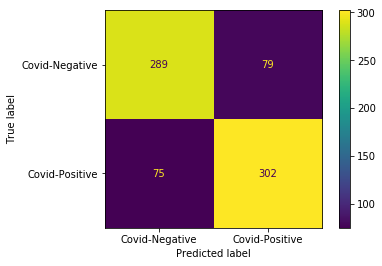

In [20]:
print("Accuracy : {}".format(accuracy_score(Y_test, Y_pred2)))
print("F1-Score : {}".format(f1_score(Y_test, Y_pred2)))
print("Classification Report : ")
print(classification_report(Y_test, Y_pred2))
print("Confusion Matrix")
conf_mat = confusion_matrix(Y_test, Y_pred2, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Covid-Negative", "Covid-Positive"])
disp.plot();

By setting the threshold to 0.2, we can see in the confusion matrix that we are detecting more true positive cases, we went from 297 to 302 true positive cases.

But this comes with a higher false positive rate, as we can see that we went from 73 to 79 false positives.

This threshold can be set according to what the specialists want.

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

RandomForestClassifier()

Accuracy : 0.9020134228187919
F1-Score : 0.9004092769440655
Classification Report : 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       368
           1       0.93      0.88      0.90       377

    accuracy                           0.90       745
   macro avg       0.90      0.90      0.90       745
weighted avg       0.90      0.90      0.90       745

Confusion Matrix


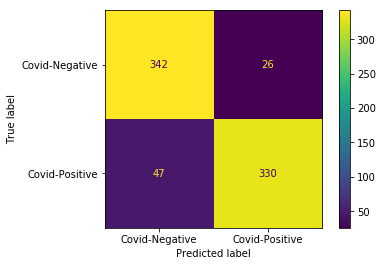

In [22]:
Y_pred = rf.predict(X_test)
print("Accuracy : {}".format(accuracy_score(Y_test, Y_pred)))
print("F1-Score : {}".format(f1_score(Y_test, Y_pred)))
print("Classification Report : ")
print(classification_report(Y_test, Y_pred))
print("Confusion Matrix")
conf_mat = confusion_matrix(Y_test, Y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Covid-Negative", "Covid-Positive"])
disp.plot();

We can do the same thing as with Logistic Regression, and use a threshold to decide : 

In [23]:
Y_pred_probas = rf.predict_proba(X_test)
Y_pred_probas = Y_pred_probas[:,1]
DECISION_THRESHOLD = 0.4
Y_pred2 = (Y_pred_probas > DECISION_THRESHOLD).astype(int)

Accuracy : 0.8791946308724832
F1-Score : 0.8852040816326531
Classification Report : 
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       368
           1       0.85      0.92      0.89       377

    accuracy                           0.88       745
   macro avg       0.88      0.88      0.88       745
weighted avg       0.88      0.88      0.88       745

Confusion Matrix


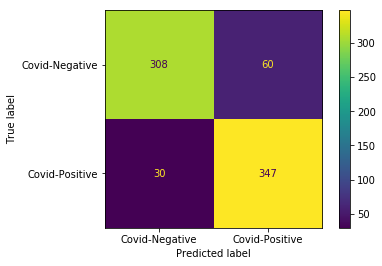

In [24]:
print("Accuracy : {}".format(accuracy_score(Y_test, Y_pred2)))
print("F1-Score : {}".format(f1_score(Y_test, Y_pred2)))
print("Classification Report : ")
print(classification_report(Y_test, Y_pred2))
print("Confusion Matrix")
conf_mat = confusion_matrix(Y_test, Y_pred2, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["Covid-Negative", "Covid-Positive"])
disp.plot();

We can see here that we get far less false negative than without setting a threshold (0.5 by default)

We can see after this brief analysis that Random Forests performs better on this data, because of its ability to learn non-linear relationships.

We have also seen how simple methods can be used to classify images. Although, these methods do not take into consideration the spatial aspect of the image, and an important part is thus lost.
- To fix this problem, we need to use methods that consider the spatial correlations of the data. Such as Convolutional Neural Networks, or SKDA (Spatial Kernel Discriminant Analysis)